In [1]:
# Stagnant lid convection model

%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

In [2]:
dim = 2

In [3]:
# create mesh objects
elementMesh = uw.mesh.FeMesh_Cartesian( elementType='Q2/dPc1', 
                                         elementRes=(32,32), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,1.)  )

linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

In [4]:
# create fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

In [5]:
# Initialise data.. Note that we are also setting boundary conditions here

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.

# Setup temperature initial condition via underlying data viewed as numpy arrays

toptemp = 0.
bottomtemp = 1.
scaleFactor = bottomtemp - toptemp
import math
tempData = temperatureField.data
perturbation_scale = 0.1
for index, coord in enumerate(linearMesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    tempData[index] = min(1,max(0,toptemp + scaleFactor*(1. - coord[1]) + perturbation_scale * pertCoeff ));

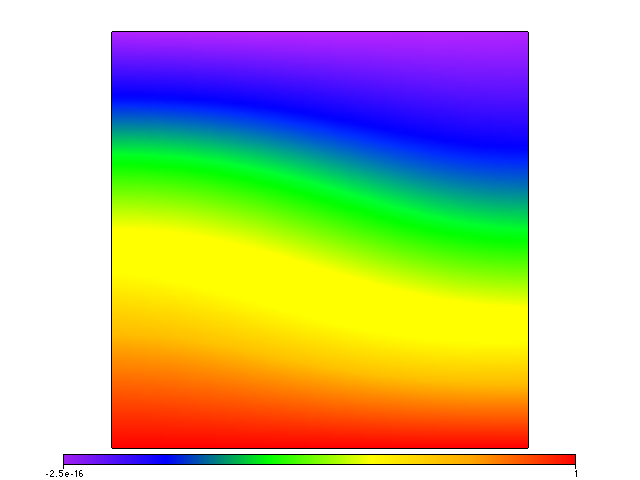

In [6]:
figtemp = plt.Figure()
tempminmax = fn.view.min_max(temperatureField)
figtemp.Surface(tempminmax, elementMesh)
figtemp.show()

In [7]:
# Get list of special sets.
# These are sets of vertices on the mesh. In this case we want to set them as boundary conditions.
linearMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

In [8]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]

In [9]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(IWalls,JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

In [10]:
# lets ensure temp boundaries are still what we want as the IC above might have set slightly different values
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = 1.
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = 0

In [11]:
# Rheology

eta0 = 1.0e-6
activationEnergy = 27.63102112
Ra = 1.e6
viscosityFn = eta0 *  fn.math.exp( activationEnergy / (temperatureField+1.) ) 

densityFn = Ra*temperatureField
# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )
# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading
buoyancyFn = gravity*densityFn

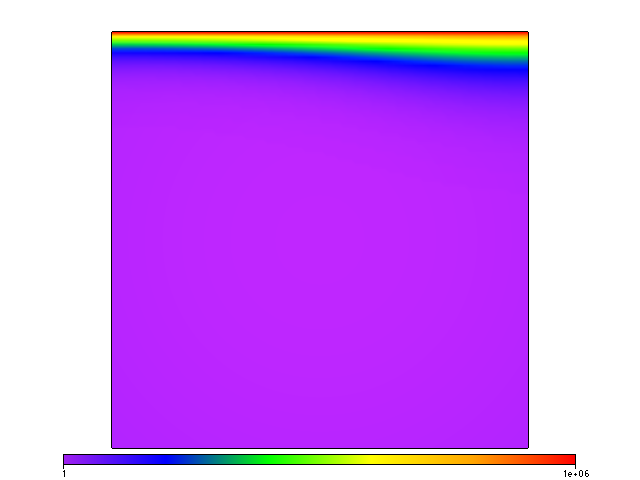

In [12]:
# lets take a look at the eta function
figEta = plt.Figure()
figEta.Surface(viscosityFn, linearMesh)
figEta.show()

In [13]:
# Setup a stokes system
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityFn), 
                              bodyForceFn=buoyancyFn )

solver=uw.systems.Solver(stokesPIC)

solver.options.main.Q22_pc_type='uw'  # also try 'gtkg', 'gkgdiag' and 'uwscale'
solver.options.main.penalty = 1.0
solver.options.A11.ksp_rtol=1e-4
solver.options.scr.ksp_rtol=1e-3
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 1
solver.options.mg.levels = 5
solver.options.mg.mg_levels_ksp_type = 'chebyshev'
solver.options.mg_accel.mg_accelerating_smoothing = True
solver.options.mg_accel.mg_accelerating_smoothing_view = False
solver.options.mg_accel.mg_smooths_to_start = 1

stokesPIC.solve = solver.solve


#  and we can check what we put in / the defaults:

print "## Solver Config"
print solver.options.main.list()
print "### A11 Config"
print solver.options.A11.list()

## Solver Config
('remove_constant_pressure_null_space', False)
('ksp_k2_type', 'GMG')
('change_backsolve', False)
('penalty', 1.0)
('pc_type', 'none')
('force_correction', True)
('k_scale_only', True)
('Q22_pc_type', 'uw')
('change_A11rhspresolve', False)
('ksp_type', 'bsscr')
('rescale_equations', False)
('restore_K', True)
None
### A11 Config
('ksp_type', 'fgmres')
('ksp_rtol', 0.0001)
None


In [14]:
# Create advdiff system
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,] )
# Also create some integral objects which are used to calculate statistics.
v2sum_integral  = uw.utils.Integral( feMesh=linearMesh, fn=fn.math.dot(velocityField, velocityField) ) 
volume_integral = uw.utils.Integral( feMesh=linearMesh, fn=1. )

In [15]:
#surface_Tgradient = uw.utils.Integral(temperatureField.gradientFn[1], linearMesh, integrationType="surface", surfaceIndexSet=linearMesh.specialSets["MaxJ_VertexSet"])
#basalT            = uw.utils.Integral(temperatureField              , linearMesh, integrationType="surface", surfaceIndexSet=linearMesh.specialSets["MinJ_VertexSet"])

RuntimeError: Surface integrals are currently disabled.

In [16]:
# Stepping. Initialise time and timestep.
realtime = 0.
step = 0
figtemp = plt.Figure()
figtemp.Surface(temperatureField, linearMesh)
time_vals = []
vrms_vals = []
Nu_vals = []

In [17]:
import time

start = time.clock()
# Perform 1000 steps

volume = volume_integral.integrate()
while step<2:
    # Get solution for initial configuration
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep siz    
    advDiff.integrate(dt)
    
    # Calculate the RMS velocity
    v2sum = v2sum_integral.integrate()
    rms_v = math.sqrt(v2sum[0]/volume[0])
#    nu_no = -surface_Tgradient.integrate()[0] / basalT.integrate()[0]
    
    # Increment time and store results
    realtime += dt
    step += 1
    vrms_vals.append( rms_v )
    time_vals.append( realtime )
#    Nu_vals.append(nu_no)
                   
    if step ==0 or step % 25 == 0:
        print "step = {:04d}; time = {:.6f}, vrms = {:6.2f}, CPU = {:4.1f}s".format(
               step, realtime, rms_v, time.clock()-start)


In [ ]:
print "average per timestep = ", (time.clock() - start)/float(step), " over ", step, " steps"

In [ ]:
figVT = plt.Figure()
figVT.Surface(temperatureField, linearMesh)
figVT.VectorArrows(velocityField, linearMesh, lengthScale=0.00075, arrowHeadSize=0.2 )
figVT.show()

In [ ]:
import matplotlib.pyplot as pyplot
#import numpy as np

surface_points_X = linearMesh.data[linearMesh.specialSets["MinJ_VertexSet"].data].T[0]

figure, (plot1, plot2) = pyplot.subplots(1,2)
figure.set_size_inches(10,6)
plot1.plot(time_vals, vrms_vals, linewidth=2.5)
#plot2.plot(time_vals, Nu_vals, linewidth=2.5)

figure.show()